# COMP9417 group project Word2vec model

## Group Member: 
                Meng Xiao(z5298034) 
                Feiyu Qiao(z5324320) 
                Huizhe Sun(z5375498) 
                Xinchen Zou(z5378240) 
                Bowen Zhao(z5446616) 

# Please run this file under Kaggle environment:
# https://www.kaggle.com/code/simonxm/comp9417-project/notebook?scriptVersionId=138794837

# And download the dataset:
# https://www.kaggle.com/datasets/simonxm/w2vec-model

In [ ]:
import polars as pl
from gensim.models import Word2Vec
import gc

# import dataset
train_set = pl.read_parquet('/kaggle/input/w2vec-model/train.parquet')
test_set = pl.read_parquet('/kaggle/input/w2vec-model/test.parquet')

In [2]:
# pre-process the data
# covert the discreted aids into sentence and input them
sentences_df = pl.concat([train_set, test_set]).unique().groupby('session').agg(
    pl.col('aid').alias('sentence')
)
sentences = sentences_df['sentence'].to_list()

del sentences_df

In [3]:
# Hash function to initialize weights
def hashfxn(key):

    output = 0

    for item, character in enumerate(repr(key), start=1):
        output += item *ord(character)
        
    return output

In [4]:
import multiprocessing

cores = multiprocessing.cpu_count() 

w2vec = Word2Vec(
                 sentences=sentences, 
                 window = 3,                
                 vector_size=64,
                 min_count=1,
                 sg=1,
                 ns_exponent= 0.2,
                 negative=8,
                 workers=4,
                 hashfxn=hashfxn
                )

In [5]:
from annoy import AnnoyIndex

aid2idx = {aid: i for i, aid in enumerate(w2vec.wv.index_to_key)}
index = AnnoyIndex(64, 'angular')

for aid, idx in aid2idx.items():
    index.add_item(aid, w2vec.wv.vectors[idx])
    
index.build(32)

True

In [6]:
# make some prediction on aids
pred_test_df = pl.concat([test_set]).groupby('session').agg(pl.col('aid').alias('sentence')).to_pandas().rename(columns={'sentence':'labels'})

sentences_df_clicks = pl.concat([test_set]).filter(pl.col('type') == 0)
sentences_df_carts = pl.concat([test_set]).filter(pl.col('type') == 1)
sentences_df_orders = pl.concat([test_set]).filter(pl.col('type') == 2)

sentences_df_clicks = sentences_df_clicks.groupby('session').agg(pl.col('aid').alias('sentence')).to_pandas().rename(columns={'sentence':'labels_clicks'})
sentences_df_carts = sentences_df_carts.groupby('session').agg(pl.col('aid').alias('sentence')).to_pandas().rename(columns={'sentence':'labels_carts'})
sentences_df_orders = sentences_df_orders.groupby('session').agg(pl.col('aid').alias('sentence')).to_pandas().rename(columns={'sentence':'labels_orders'})

pred_test_df = pred_test_df.merge(sentences_df_clicks, how='left', on='session') \
                           .merge(sentences_df_carts, how='left', on='session') \
                           .merge(sentences_df_orders, how='left', on='session')

pred_test_df

,session,labels,labels_clicks,labels_carts,labels_orders
0,13728736,"[1825743, 289406, 440116]","[1825743, 289406, 440116]",NaN,NaN
1,14275280,"[932643, 186812]","[932643, 186812]",NaN,NaN
2,14333264,[125957],[125957],NaN,NaN
3,13220688,"[295859, 1517911, 1750274, 1750274, 1038449, 1...","[295859, 1517911, 1750274, 1750274, 1038449, 1...",NaN,NaN
4,14494528,"[175329, 174509, 175329]","[175329, 174509, 175329]",NaN,NaN
...,...,...,...,...,...
1671798,14287807,[1486938],[1486938],NaN,NaN
1671799,14294447,"[1005882, 1005882]",[1005882],[1005882],NaN
1671800,13339823,[193634],[193634],NaN,NaN
1671801,13971983,"[1628544, 972504]","[1628544, 972504]",NaN,NaN


In [7]:
import pandas as pd
import numpy as np

from collections import defaultdict
import collections


session_types = ['clicks', 'carts', 'orders']
test_session_AIDs = test_set.to_pandas().reset_index(drop=True).groupby('session')['aid'].apply(list)
test_session_types = test_set.to_pandas().reset_index(drop=True).groupby('session')['type'].apply(list)

output = []

type_weight_multipliers = {0: 1, 1: 6, 2: 3}
for AIDs, types in zip(test_session_AIDs, test_session_types):
    if len(AIDs) >= 20:
        # if we have over 20 aids, just use the log with given weights
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
        aids_temp=defaultdict(lambda: 0)
        for aid,w,t in zip(AIDs,weights,types): 
            aids_temp[aid]+= w * type_weight_multipliers[t]
            
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
        output.append(sorted_aids[:20])
    else:
        AIDs = list(dict.fromkeys(AIDs[::-1]))
        
        most_recent_aid = AIDs[0]
        # looking for neighbour to print
        nns = [w2vec.wv.index_to_key[i] for i in index.get_nns_by_item(aid2idx[most_recent_aid], 21)[1:]]
                        
        output.append((AIDs+nns)[:20])

In [8]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in output]

predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

submission = pd.concat(prediction_dfs).reset_index(drop=True)


In [9]:
submission.to_csv('submission_.csv', index=False)

del prediction_dfs

gc.collect()

0

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\user\AppData\Local\Programs\Python\Python311\

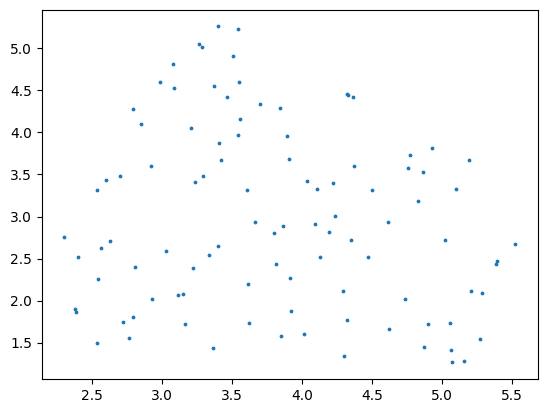

In [10]:
# Add visualization content
import matplotlib.pyplot as plt
import umap.umap_ as umap

vocab = []

# show 100 random aid in the dot plot, to check their relative distance
for i in range(100):
    vocab.append(w2vec.wv.key_to_index[i])
X = w2vec.wv[vocab]

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)
plt.figure(1)
plt.scatter(cluster_embedding[:,0], cluster_embedding[:,1], s=3, cmap='Spectral')

As we can see in the above graph, the data is discrete. Two **adjoin** AIDs are considered as recommended  product to each other.

In [11]:
submission.head()

,session_type,labels
0,12899779_clicks,59625 571260 1712451 1211029 1398778 286417 33...
1,12899780_clicks,1142000 736515 973453 582732 1515891 139305 91...
2,12899781_clicks,918667 199008 194067 57315 141736 141648 10860...
3,12899782_clicks,834354 595994 740494 889671 987399 779477 1344...
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 ...
